# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/ano_VAE+Centerloss/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [15]:
#path='/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/test_ex22/models/ToyCar_model.pth'
#pretrained_dict = torch.load(path)

In [16]:
#pretrained_dict['center_loss.centers'].shape

In [17]:
#pretrained_dict['center_loss.centers']

2021-08-11 13:08:26,956 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-08-11 13:08:26,956 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 13:08:28,945 - 00_train.py - INFO - TRAINING
2021-08-11 13:08:32,052 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 14.00it/s]
2021-08-11 13:08:32,912 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.57it/s]
2021-08-11 13:08:32,962 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.65it/s]


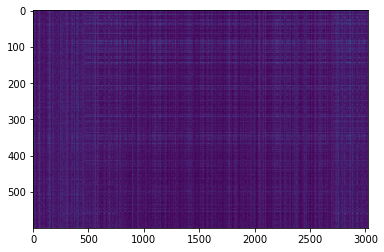

AUC      pAUC
Source_0  0.477100  0.522632
Source_1  0.570200  0.515263
Source_2  0.456200  0.497368
Target_0  0.482300  0.506316
Target_1  0.534100  0.504211
Target_2  0.417500  0.509474
mean      0.489567  0.509211
h_mean    0.484547  0.509083

2021-08-11 13:08:34,114 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:35904.303874, val_AUC_hmean:0.484547, val_pAUC_hmean:0.509083, best_flag:True
2021-08-11 13:08:34,115 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.28it/s]
2021-08-11 13:08:34,542 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 100.26it/s]
2021-08-11 13:08:34,582 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.09it/s]
2021-08-11 13:08:34,622 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:28549.728190, val_AUC_hmean:0.455917, val_pAUC_hmean:0.503541, best_flag:False
2021-08-11 13:08:34,623 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.38it/s]
2021-08-11 13:08:35,048 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 100.41it/s]
2021-08-11 13:08:35,088 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.77it/s]
2021-08-11 1

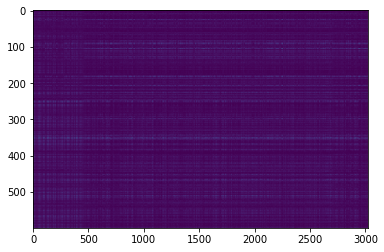

AUC      pAUC
Source_0  0.528500  0.539474
Source_1  0.584500  0.537895
Source_2  0.319800  0.486842
Target_0  0.466100  0.494737
Target_1  0.594400  0.528947
Target_2  0.304200  0.485263
mean      0.466250  0.512193
h_mean    0.433366  0.511101

2021-08-11 13:08:38,512 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:21994.395345, val_AUC_hmean:0.433366, val_pAUC_hmean:0.511101, best_flag:True
2021-08-11 13:08:38,513 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-08-11 13:08:38,971 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.95it/s]
2021-08-11 13:08:39,009 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.29it/s]


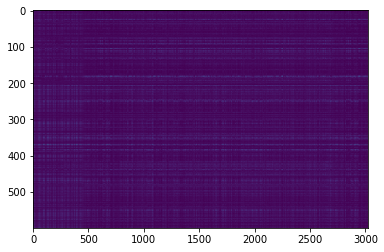

AUC      pAUC
Source_0  0.545000  0.550000
Source_1  0.590600  0.539474
Source_2  0.342000  0.486842
Target_0  0.470600  0.493684
Target_1  0.595600  0.544737
Target_2  0.302100  0.485263
mean      0.474317  0.516667
h_mean    0.442278  0.515111

2021-08-11 13:08:40,174 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:21462.208333, val_AUC_hmean:0.442278, val_pAUC_hmean:0.515111, best_flag:True
2021-08-11 13:08:40,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.48it/s]
2021-08-11 13:08:40,668 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.18it/s]
2021-08-11 13:08:40,717 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.99it/s]
2021-08-11 13:08:40,780 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:20859.935710, val_AUC_hmean:0.447590, val_pAUC_hmean:0.507480, best_flag:False
2021-08-11 13:08:40,783 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.67it/s]
2021-08-11 13:08:41,218 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 100.83it/s]
2021-08-11 13:08:41,257 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.27it/s]


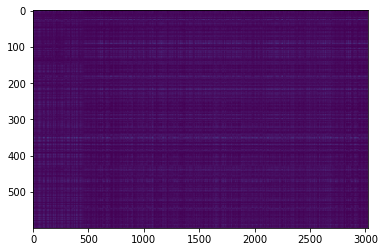

AUC      pAUC
Source_0  0.560700  0.560000
Source_1  0.606600  0.548421
Source_2  0.393800  0.486842
Target_0  0.489500  0.498947
Target_1  0.622600  0.560526
Target_2  0.311100  0.485789
mean      0.497383  0.523421
h_mean    0.467477  0.521288

2021-08-11 13:08:42,392 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:20344.761230, val_AUC_hmean:0.467477, val_pAUC_hmean:0.521288, best_flag:True
2021-08-11 13:08:42,393 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.46it/s]
2021-08-11 13:08:42,885 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.91it/s]
2021-08-11 13:08:42,923 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.36it/s]
2021-08-11 13:08:42,965 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:19977.392253, val_AUC_hmean:0.453480, val_pAUC_hmean:0.510218, best_flag:False
2021-08-11 13:08:42,966 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.25it/s]
2021-08-11 13:08:43,443 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.99it/s]
2021-08-11 13:08:43,482 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.12it/s]
2021-08-11 1

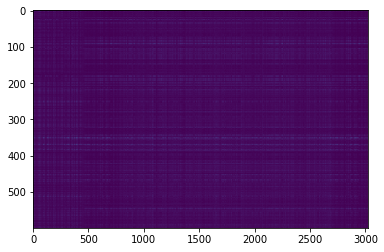

AUC      pAUC
Source_0  0.562900  0.604211
Source_1  0.599500  0.528947
Source_2  0.346800  0.480526
Target_0  0.540100  0.506842
Target_1  0.661800  0.547368
Target_2  0.346000  0.480526
mean      0.509517  0.524737
h_mean    0.476918  0.521393

2021-08-11 13:08:48,463 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:17489.175944, val_AUC_hmean:0.476918, val_pAUC_hmean:0.521393, best_flag:True
2021-08-11 13:08:48,464 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.39it/s]
2021-08-11 13:08:48,921 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.90it/s]
2021-08-11 13:08:48,959 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.01it/s]
2021-08-11 13:08:49,000 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:17366.263997, val_AUC_hmean:0.484417, val_pAUC_hmean:0.515154, best_flag:False
2021-08-11 13:08:49,001 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-08-11 13:08:49,458 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.16it/s]
2021-08-11 13:08:49,497 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.17it/s]
2021-08-11 1

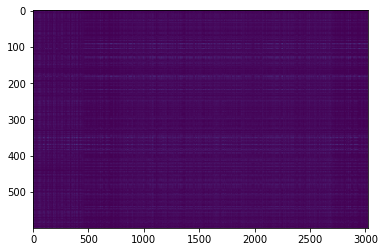

AUC      pAUC
Source_0  0.535000  0.554211
Source_1  0.589300  0.510000
Source_2  0.377700  0.490000
Target_0  0.565800  0.512105
Target_1  0.685600  0.598947
Target_2  0.375800  0.492105
mean      0.521533  0.526228
h_mean    0.495840  0.523543

2021-08-11 13:08:53,794 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:16191.684082, val_AUC_hmean:0.495840, val_pAUC_hmean:0.523543, best_flag:True
2021-08-11 13:08:53,795 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.07it/s]
2021-08-11 13:08:54,395 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.58it/s]
2021-08-11 13:08:54,437 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.68it/s]
2021-08-11 13:08:54,481 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:15942.682617, val_AUC_hmean:0.503735, val_pAUC_hmean:0.516867, best_flag:False
2021-08-11 13:08:54,482 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.73it/s]
2021-08-11 13:08:54,917 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.51it/s]
2021-08-11 13:08:54,957 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.51it/s]
2021-08-11 1

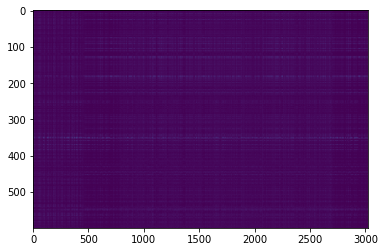

AUC      pAUC
Source_0  0.576700  0.561579
Source_1  0.590200  0.511579
Source_2  0.382300  0.489474
Target_0  0.531600  0.514211
Target_1  0.701800  0.608421
Target_2  0.346900  0.491053
mean      0.521583  0.529386
h_mean    0.490485  0.526168

2021-08-11 13:09:02,747 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:14154.392660, val_AUC_hmean:0.490485, val_pAUC_hmean:0.526168, best_flag:True
2021-08-11 13:09:02,748 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.36it/s]
2021-08-11 13:09:03,172 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 105.49it/s]
2021-08-11 13:09:03,211 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.29it/s]
2021-08-11 13:09:03,252 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:14140.093506, val_AUC_hmean:0.485884, val_pAUC_hmean:0.510045, best_flag:False
2021-08-11 13:09:03,253 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.00it/s]
2021-08-11 13:09:03,683 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.76it/s]
2021-08-11 13:09:03,725 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 80.19it/s]


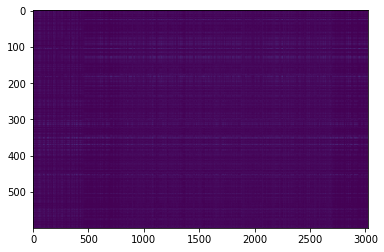

AUC      pAUC
Source_0  0.556100  0.570000
Source_1  0.596400  0.519474
Source_2  0.388800  0.491053
Target_0  0.551500  0.514737
Target_1  0.686000  0.585789
Target_2  0.369900  0.500000
mean      0.524783  0.530175
h_mean    0.499111  0.527905

2021-08-11 13:09:04,791 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:13971.883057, val_AUC_hmean:0.499111, val_pAUC_hmean:0.527905, best_flag:True
2021-08-11 13:09:04,792 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.58it/s]
2021-08-11 13:09:05,230 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.39it/s]
2021-08-11 13:09:05,270 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.98it/s]
2021-08-11 13:09:05,316 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:13864.469645, val_AUC_hmean:0.500800, val_pAUC_hmean:0.512849, best_flag:False
2021-08-11 13:09:05,318 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.39it/s]
2021-08-11 13:09:05,742 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.77it/s]
2021-08-11 13:09:05,784 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.90it/s]
2021-08-11 13

100%|██████████| 2/2 [00:00<00:00, 95.67it/s]
2021-08-11 13:09:13,753 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.92it/s]
2021-08-11 13:09:13,797 - pytorch_modeler.py - INFO - epoch:60/100, train_losses:12606.731283, val_AUC_hmean:0.496459, val_pAUC_hmean:0.518563, best_flag:False
2021-08-11 13:09:13,798 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.86it/s]
2021-08-11 13:09:14,231 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.82it/s]
2021-08-11 13:09:14,270 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.27it/s]
2021-08-11 13:09:14,311 - pytorch_modeler.py - INFO - epoch:61/100, train_losses:12370.691162, val_AUC_hmean:0.500052, val_pAUC_hmean:0.515677, best_flag:False
2021-08-11 13:09:14,312 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.98it/s]
2021-08-11 13:09:14,743 - pytorch_modeler.py - INFO - valid_source
100%|██████

2021-08-11 13:09:22,566 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.11it/s]
2021-08-11 13:09:23,010 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.38it/s]
2021-08-11 13:09:23,048 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.68it/s]
2021-08-11 13:09:23,090 - pytorch_modeler.py - INFO - epoch:77/100, train_losses:11389.595459, val_AUC_hmean:0.487547, val_pAUC_hmean:0.517994, best_flag:False
2021-08-11 13:09:23,091 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.57it/s]
2021-08-11 13:09:23,529 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.68it/s]
2021-08-11 13:09:23,567 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.39it/s]
2021-08-11 13:09:23,609 - pytorch_modeler.py - INFO - epoch:78/100, train_losses:11332.125244, val_AUC_hmean:0.494496, val_pAUC_hmean:0.523441, best_flag:False
2021-08-11 1

100%|██████████| 2/2 [00:00<00:00, 94.69it/s]
2021-08-11 13:09:31,680 - pytorch_modeler.py - INFO - epoch:93/100, train_losses:10421.719727, val_AUC_hmean:0.490722, val_pAUC_hmean:0.515416, best_flag:False
2021-08-11 13:09:31,681 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.89it/s]
2021-08-11 13:09:32,113 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.77it/s]
2021-08-11 13:09:32,154 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.59it/s]
2021-08-11 13:09:32,200 - pytorch_modeler.py - INFO - epoch:94/100, train_losses:10368.858724, val_AUC_hmean:0.484915, val_pAUC_hmean:0.519625, best_flag:False
2021-08-11 13:09:32,201 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.22it/s]
2021-08-11 13:09:32,644 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.70it/s]
2021-08-11 13:09:32,681 - pytorch_modeler.py - INFO - valid_target
100%|███████

AUC      pAUC
Source_0  0.556100  0.570000
Source_1  0.596400  0.519474
Source_2  0.388800  0.491053
Target_0  0.551500  0.514737
Target_1  0.686000  0.585789
Target_2  0.369900  0.500000
mean      0.524783  0.530175
h_mean    0.499111  0.527905

2021-08-11 13:09:35,386 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-11 13:09:35,386 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 68.429811954 [sec]


2021-08-11 13:09:35,976 - 00_train.py - INFO - TRAINING
2021-08-11 13:09:36,233 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 27.89it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 27.51it/s]
2021-08-11 13:09:36,672 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 72.92it/s]
2021-08-11 13:09:36,721 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.61it/s]


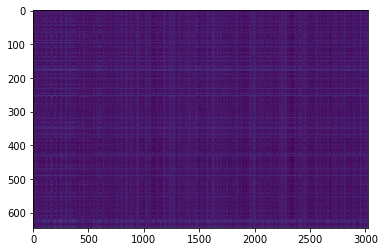

AUC      pAUC
Source_0  0.471893  0.508515
Source_1  0.412980  0.477745
Source_2  0.636876  0.484773
Target_0  0.570602  0.503533
Target_1  0.302641  0.473684
Target_2  0.581190  0.489766
mean      0.496030  0.489669
h_mean    0.465546  0.489342

2021-08-11 13:09:37,786 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:31829.081868, val_AUC_hmean:0.465546, val_pAUC_hmean:0.489342, best_flag:True
2021-08-11 13:09:37,787 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.92it/s]
2021-08-11 13:09:38,218 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.81it/s]
2021-08-11 13:09:38,264 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.98it/s]


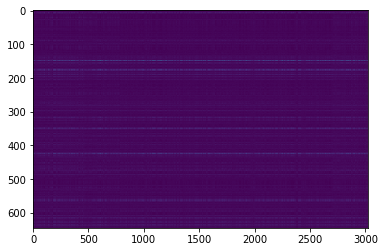

AUC      pAUC
Source_0  0.462271  0.510700
Source_1  0.475394  0.488033
Source_2  0.632515  0.502076
Target_0  0.641300  0.569830
Target_1  0.371056  0.473684
Target_2  0.630556  0.540100
mean      0.535515  0.514071
h_mean    0.513348  0.512103

2021-08-11 13:09:39,311 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:26917.336263, val_AUC_hmean:0.513348, val_pAUC_hmean:0.512103, best_flag:True
2021-08-11 13:09:39,312 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.66it/s]
2021-08-11 13:09:39,748 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.40it/s]
2021-08-11 13:09:39,792 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.21it/s]


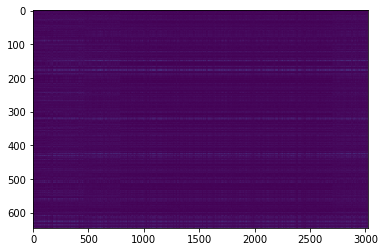

AUC      pAUC
Source_0  0.497582  0.509158
Source_1  0.467421  0.494621
Source_2  0.613661  0.523759
Target_0  0.719907  0.608004
Target_1  0.404578  0.474406
Target_2  0.647460  0.575606
mean      0.558435  0.530926
h_mean    0.536483  0.527010

2021-08-11 13:09:40,845 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:25398.111003, val_AUC_hmean:0.536483, val_pAUC_hmean:0.527010, best_flag:True
2021-08-11 13:09:40,846 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.62it/s]
2021-08-11 13:09:41,282 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.59it/s]
2021-08-11 13:09:41,325 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.98it/s]


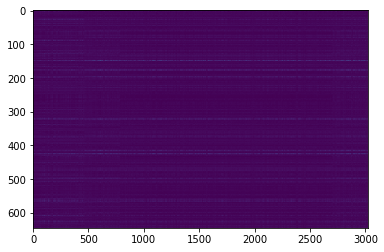

AUC      pAUC
Source_0  0.509548  0.506330
Source_1  0.508488  0.488394
Source_2  0.625201  0.535978
Target_0  0.751640  0.620594
Target_1  0.457990  0.481897
Target_2  0.650952  0.580409
mean      0.583970  0.535600
h_mean    0.567177  0.531082

2021-08-11 13:09:42,425 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:24370.138835, val_AUC_hmean:0.567177, val_pAUC_hmean:0.531082, best_flag:True
2021-08-11 13:09:42,426 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.83it/s]
2021-08-11 13:09:42,978 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.33it/s]
2021-08-11 13:09:43,029 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.22it/s]
2021-08-11 13:09:43,072 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:23499.300618, val_AUC_hmean:0.554065, val_pAUC_hmean:0.524630, best_flag:False
2021-08-11 13:09:43,073 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.88it/s]
2021-08-11 13:09:43,506 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.64it/s]
2021-08-11 13:09:43,548 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.57it/s]
2021-08-11 13:0

100%|██████████| 2/2 [00:00<00:00, 87.48it/s]
2021-08-11 13:09:51,411 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.15it/s]
2021-08-11 13:09:51,454 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:17656.343913, val_AUC_hmean:0.575371, val_pAUC_hmean:0.518849, best_flag:False
2021-08-11 13:09:51,455 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.49it/s]
2021-08-11 13:09:51,893 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.51it/s]
2021-08-11 13:09:51,935 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.58it/s]
2021-08-11 13:09:51,981 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:17522.403646, val_AUC_hmean:0.595005, val_pAUC_hmean:0.516580, best_flag:False
2021-08-11 13:09:51,982 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-08-11 13:09:52,431 - pytorch_modeler.py - INFO - valid_source
100%|██████

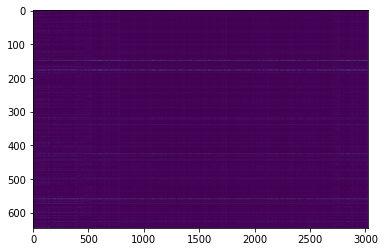

AUC      pAUC
Source_0  0.599219  0.543603
Source_1  0.597651  0.526207
Source_2  0.559917  0.513165
Target_0  0.804398  0.600288
Target_1  0.578361  0.529637
Target_2  0.495952  0.500418
mean      0.605916  0.535553
h_mean    0.593088  0.533763

2021-08-11 13:09:59,554 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:15498.600830, val_AUC_hmean:0.593088, val_pAUC_hmean:0.533763, best_flag:True
2021-08-11 13:09:59,555 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.65it/s]
2021-08-11 13:09:59,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.32it/s]
2021-08-11 13:10:00,035 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.84it/s]
2021-08-11 13:10:00,079 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:15460.970052, val_AUC_hmean:0.592326, val_pAUC_hmean:0.528510, best_flag:False
2021-08-11 13:10:00,080 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.40it/s]
2021-08-11 13:10:00,520 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.11it/s]
2021-08-11 13:10:00,562 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.97it/s]


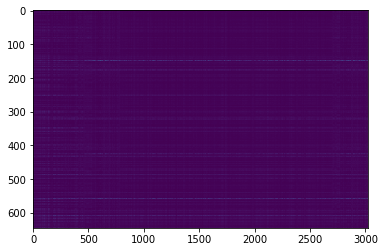

AUC      pAUC
Source_0  0.596190  0.552085
Source_1  0.634431  0.526659
Source_2  0.603663  0.516767
Target_0  0.816358  0.589831
Target_1  0.606310  0.533517
Target_2  0.521587  0.509816
mean      0.629757  0.538113
h_mean    0.618456  0.536844

2021-08-11 13:10:01,621 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:15137.530924, val_AUC_hmean:0.618456, val_pAUC_hmean:0.536844, best_flag:True
2021-08-11 13:10:01,622 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.46it/s]
2021-08-11 13:10:02,061 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.63it/s]
2021-08-11 13:10:02,105 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.22it/s]
2021-08-11 13:10:02,148 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:15029.134440, val_AUC_hmean:0.586865, val_pAUC_hmean:0.525317, best_flag:False
2021-08-11 13:10:02,149 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.73it/s]
2021-08-11 13:10:02,584 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.29it/s]
2021-08-11 13:10:02,626 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.90it/s]
2021-08-11 13

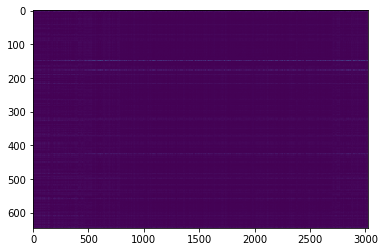

AUC      pAUC
Source_0  0.607277  0.548744
Source_1  0.663237  0.532976
Source_2  0.583199  0.514789
Target_0  0.810475  0.590745
Target_1  0.652349  0.542903
Target_2  0.518016  0.531537
mean      0.639092  0.543616
h_mean    0.627199  0.542632

2021-08-11 13:10:05,791 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:14522.620280, val_AUC_hmean:0.627199, val_pAUC_hmean:0.542632, best_flag:True
2021-08-11 13:10:05,792 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.95it/s]
2021-08-11 13:10:06,223 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.13it/s]
2021-08-11 13:10:06,268 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.97it/s]
2021-08-11 13:10:06,311 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:14353.637451, val_AUC_hmean:0.623980, val_pAUC_hmean:0.524747, best_flag:False
2021-08-11 13:10:06,312 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.01it/s]
2021-08-11 13:10:06,758 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.58it/s]
2021-08-11 13:10:06,803 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


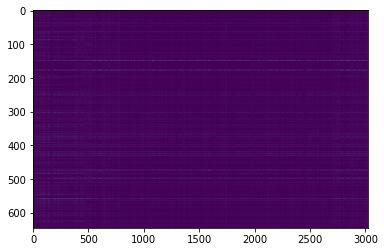

AUC      pAUC
Source_0  0.597167  0.563524
Source_1  0.661008  0.547235
Source_2  0.570652  0.516343
Target_0  0.815008  0.611355
Target_1  0.641204  0.542001
Target_2  0.522698  0.492481
mean      0.634623  0.545490
h_mean    0.622439  0.542993

2021-08-11 13:10:07,893 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:14201.718913, val_AUC_hmean:0.622439, val_pAUC_hmean:0.542993, best_flag:True
2021-08-11 13:10:07,894 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.85it/s]
2021-08-11 13:10:08,327 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.16it/s]
2021-08-11 13:10:08,371 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.53it/s]


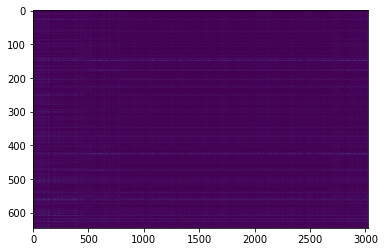

AUC      pAUC
Source_0  0.630672  0.553628
Source_1  0.613426  0.518988
Source_2  0.629563  0.522700
Target_0  0.829379  0.617345
Target_1  0.583248  0.521876
Target_2  0.576429  0.538221
mean      0.643786  0.545459
h_mean    0.634297  0.543467

2021-08-11 13:10:09,471 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:13955.129801, val_AUC_hmean:0.634297, val_pAUC_hmean:0.543467, best_flag:True
2021-08-11 13:10:09,472 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.64it/s]
2021-08-11 13:10:09,908 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.14it/s]
2021-08-11 13:10:09,950 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.97it/s]
2021-08-11 13:10:09,993 - pytorch_modeler.py - INFO - epoch:46/100, train_losses:13852.555745, val_AUC_hmean:0.599703, val_pAUC_hmean:0.537590, best_flag:False
2021-08-11 13:10:09,995 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.62it/s]
2021-08-11 13:10:10,431 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.97it/s]
2021-08-11 13:10:10,481 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.20it/s]
2021-08-11 13

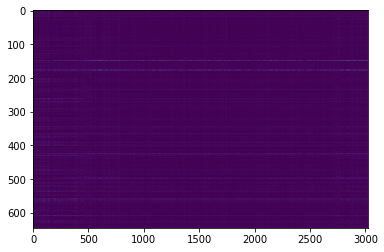

AUC      pAUC
Source_0  0.586227  0.544117
Source_1  0.671811  0.555628
Source_2  0.584138  0.515072
Target_0  0.826678  0.652676
Target_1  0.622857  0.546874
Target_2  0.504524  0.489140
mean      0.632706  0.550584
h_mean    0.618334  0.546238

2021-08-11 13:10:12,160 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:13709.307292, val_AUC_hmean:0.618334, val_pAUC_hmean:0.546238, best_flag:True
2021-08-11 13:10:12,160 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.75it/s]
2021-08-11 13:10:12,595 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.14it/s]
2021-08-11 13:10:12,638 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.65it/s]
2021-08-11 13:10:12,682 - pytorch_modeler.py - INFO - epoch:49/100, train_losses:13509.721110, val_AUC_hmean:0.629560, val_pAUC_hmean:0.543078, best_flag:False
2021-08-11 13:10:12,683 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.93it/s]
2021-08-11 13:10:13,114 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.58it/s]
2021-08-11 13:10:13,156 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.04it/s]
2021-08-11 13

100%|██████████| 2/2 [00:00<00:00, 83.90it/s]
2021-08-11 13:10:21,184 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.74it/s]
2021-08-11 13:10:21,226 - pytorch_modeler.py - INFO - epoch:65/100, train_losses:12076.629069, val_AUC_hmean:0.629710, val_pAUC_hmean:0.542840, best_flag:False
2021-08-11 13:10:21,227 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.83it/s]
2021-08-11 13:10:21,677 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.68it/s]
2021-08-11 13:10:21,720 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.70it/s]
2021-08-11 13:10:21,767 - pytorch_modeler.py - INFO - epoch:66/100, train_losses:11900.378906, val_AUC_hmean:0.647727, val_pAUC_hmean:0.541461, best_flag:False
2021-08-11 13:10:21,769 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.19it/s]
2021-08-11 13:10:22,212 - pytorch_modeler.py - INFO - valid_source
100%|███████

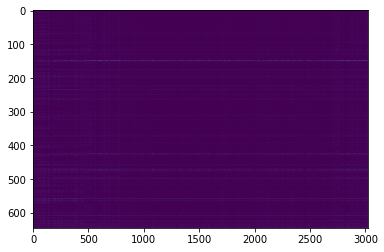

AUC      pAUC
Source_0  0.604347  0.553242
Source_1  0.673011  0.570609
Source_2  0.659085  0.520228
Target_0  0.807581  0.548307
Target_1  0.647205  0.548859
Target_2  0.587222  0.548872
mean      0.663075  0.548353
h_mean    0.656161  0.547948

2021-08-11 13:10:23,464 - pytorch_modeler.py - INFO - epoch:67/100, train_losses:11820.159749, val_AUC_hmean:0.656161, val_pAUC_hmean:0.547948, best_flag:True
2021-08-11 13:10:23,465 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.99it/s]
2021-08-11 13:10:23,912 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.07it/s]
2021-08-11 13:10:23,956 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.58it/s]
2021-08-11 13:10:23,998 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:11724.235514, val_AUC_hmean:0.647616, val_pAUC_hmean:0.534888, best_flag:False
2021-08-11 13:10:23,999 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.58it/s]
2021-08-11 13:10:24,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.76it/s]
2021-08-11 13:10:24,515 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.25it/s]
2021-08-11 13

100%|██████████| 2/2 [00:00<00:00, 79.55it/s]
2021-08-11 13:10:32,921 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.16it/s]
2021-08-11 13:10:32,967 - pytorch_modeler.py - INFO - epoch:84/100, train_losses:10605.919434, val_AUC_hmean:0.650726, val_pAUC_hmean:0.541834, best_flag:False
2021-08-11 13:10:32,968 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.54it/s]
2021-08-11 13:10:33,526 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 73.85it/s]
2021-08-11 13:10:33,574 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.15it/s]
2021-08-11 13:10:33,622 - pytorch_modeler.py - INFO - epoch:85/100, train_losses:10315.401937, val_AUC_hmean:0.637030, val_pAUC_hmean:0.539508, best_flag:False
2021-08-11 13:10:33,623 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.48it/s]
2021-08-11 13:10:34,079 - pytorch_modeler.py - INFO - valid_source
100%|███████

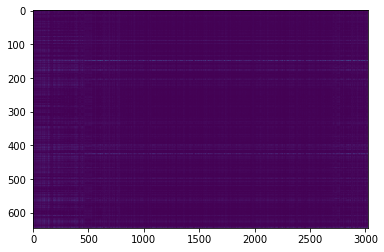

AUC      pAUC
Source_0  0.610891  0.572393
Source_1  0.709534  0.570428
Source_2  0.649960  0.527432
Target_0  0.787809  0.517442
Target_1  0.685871  0.581619
Target_2  0.615000  0.539056
mean      0.676511  0.551395
h_mean    0.671273  0.550301

2021-08-11 13:10:38,627 - pytorch_modeler.py - INFO - epoch:92/100, train_losses:9662.406087, val_AUC_hmean:0.671273, val_pAUC_hmean:0.550301, best_flag:True
2021-08-11 13:10:38,628 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.91it/s]
2021-08-11 13:10:39,111 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.41it/s]
2021-08-11 13:10:39,153 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.23it/s]
2021-08-11 13:10:39,195 - pytorch_modeler.py - INFO - epoch:93/100, train_losses:9535.074463, val_AUC_hmean:0.656617, val_pAUC_hmean:0.539194, best_flag:False
2021-08-11 13:10:39,197 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.60it/s]
2021-08-11 13:10:39,707 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.24it/s]
2021-08-11 13:10:39,761 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 76.44it/s]
2021-08-11 13:1

AUC      pAUC
Source_0  0.610891  0.572393
Source_1  0.709534  0.570428
Source_2  0.649960  0.527432
Target_0  0.787809  0.517442
Target_1  0.685871  0.581619
Target_2  0.615000  0.539056
mean      0.676511  0.551395
h_mean    0.671273  0.550301

2021-08-11 13:10:43,128 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-08-11 13:10:43,129 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 67.742118597 [sec]


2021-08-11 13:10:43,701 - 00_train.py - INFO - TRAINING
2021-08-11 13:10:44,014 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 25.12it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 26.71it/s]
2021-08-11 13:10:44,465 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.18it/s]
2021-08-11 13:10:44,503 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 105.65it/s]


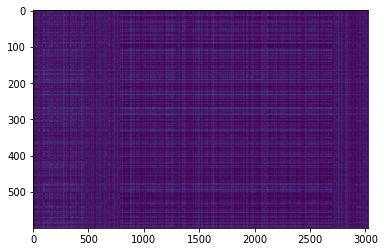

AUC      pAUC
Source_0  0.555300  0.488421
Source_1  0.556500  0.513158
Source_2  0.491600  0.517368
Target_0  0.518100  0.505263
Target_1  0.536800  0.496842
Target_2  0.469800  0.494737
mean      0.521350  0.502632
h_mean    0.519322  0.502422

2021-08-11 13:10:45,671 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:34625.999674, val_AUC_hmean:0.519322, val_pAUC_hmean:0.502422, best_flag:True
2021-08-11 13:10:45,672 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.11it/s]
2021-08-11 13:10:46,116 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.86it/s]
2021-08-11 13:10:46,161 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.56it/s]


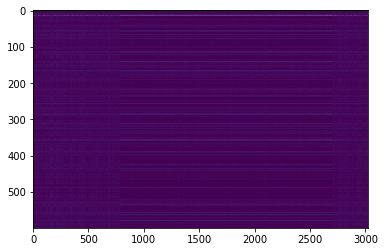

AUC      pAUC
Source_0  0.534800  0.492632
Source_1  0.540900  0.521579
Source_2  0.494000  0.516842
Target_0  0.508300  0.509474
Target_1  0.556700  0.505263
Target_2  0.472600  0.493684
mean      0.517883  0.506579
h_mean    0.516239  0.506348

2021-08-11 13:10:47,270 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:29437.689290, val_AUC_hmean:0.516239, val_pAUC_hmean:0.506348, best_flag:True
2021-08-11 13:10:47,271 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.94it/s]
2021-08-11 13:10:47,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.62it/s]
2021-08-11 13:10:47,830 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.23it/s]


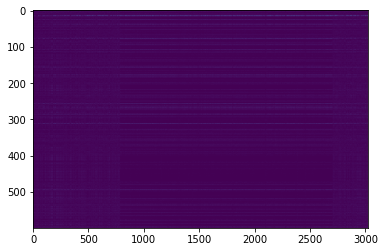

AUC      pAUC
Source_0  0.519800  0.494737
Source_1  0.540000  0.530000
Source_2  0.500700  0.517895
Target_0  0.508100  0.497368
Target_1  0.593600  0.507895
Target_2  0.465300  0.497895
mean      0.521250  0.507632
h_mean    0.518369  0.507317

2021-08-11 13:10:49,031 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:27570.548665, val_AUC_hmean:0.518369, val_pAUC_hmean:0.507317, best_flag:True
2021-08-11 13:10:49,032 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.26it/s]
2021-08-11 13:10:49,458 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.95it/s]
2021-08-11 13:10:49,497 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.13it/s]


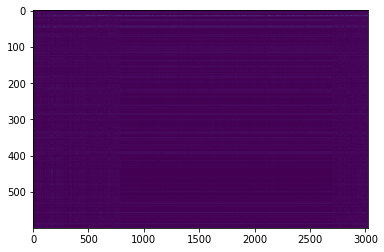

AUC      pAUC
Source_0  0.505400  0.505263
Source_1  0.539900  0.526316
Source_2  0.489900  0.519474
Target_0  0.502600  0.517895
Target_1  0.645300  0.538947
Target_2  0.468300  0.492632
mean      0.525233  0.516754
h_mean    0.519626  0.516330

2021-08-11 13:10:50,569 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:26322.859863, val_AUC_hmean:0.519626, val_pAUC_hmean:0.516330, best_flag:True
2021-08-11 13:10:50,570 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.96it/s]
2021-08-11 13:10:51,001 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.59it/s]
2021-08-11 13:10:51,040 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.02it/s]


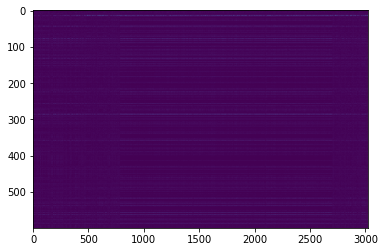

AUC      pAUC
Source_0  0.474900  0.509474
Source_1  0.514700  0.517368
Source_2  0.456700  0.514211
Target_0  0.502500  0.527895
Target_1  0.658900  0.550526
Target_2  0.493400  0.493158
mean      0.516850  0.518772
h_mean    0.509654  0.518184

2021-08-11 13:10:52,165 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:25294.374186, val_AUC_hmean:0.509654, val_pAUC_hmean:0.518184, best_flag:True
2021-08-11 13:10:52,166 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.00it/s]
2021-08-11 13:10:52,629 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.01it/s]
2021-08-11 13:10:52,669 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.43it/s]


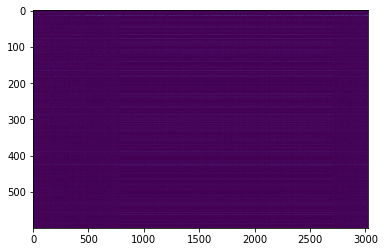

AUC      pAUC
Source_0  0.486800  0.518421
Source_1  0.514000  0.517368
Source_2  0.453900  0.509474
Target_0  0.528800  0.527368
Target_1  0.708100  0.622632
Target_2  0.455300  0.488947
mean      0.524483  0.530702
h_mean    0.512709  0.527607

2021-08-11 13:10:53,872 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:24427.077311, val_AUC_hmean:0.512709, val_pAUC_hmean:0.527607, best_flag:True
2021-08-11 13:10:53,873 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.86it/s]
2021-08-11 13:10:54,450 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.77it/s]
2021-08-11 13:10:54,496 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.83it/s]
2021-08-11 13:10:54,540 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:23744.342285, val_AUC_hmean:0.526865, val_pAUC_hmean:0.526413, best_flag:False
2021-08-11 13:10:54,542 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.59it/s]
2021-08-11 13:10:55,052 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.15it/s]
2021-08-11 13:10:55,094 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.40it/s]


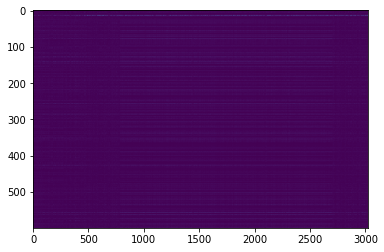

AUC      pAUC
Source_0  0.529100  0.518421
Source_1  0.550700  0.521053
Source_2  0.508200  0.507895
Target_0  0.577600  0.532632
Target_1  0.724800  0.640000
Target_2  0.442600  0.489474
mean      0.555500  0.534912
h_mean    0.543283  0.530973

2021-08-11 13:10:56,304 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:23266.893066, val_AUC_hmean:0.543283, val_pAUC_hmean:0.530973, best_flag:True
2021-08-11 13:10:56,305 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-08-11 13:10:56,772 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.33it/s]
2021-08-11 13:10:56,818 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.60it/s]
2021-08-11 13:10:56,863 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:22840.059570, val_AUC_hmean:0.540041, val_pAUC_hmean:0.517767, best_flag:False
2021-08-11 13:10:56,865 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.30it/s]
2021-08-11 13:10:57,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
2021-08-11 13:10:57,402 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.94it/s]
2021-08-11 13:1

100%|██████████| 2/2 [00:00<00:00, 88.58it/s]
2021-08-11 13:11:05,564 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.53it/s]
2021-08-11 13:11:05,606 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:17038.423340, val_AUC_hmean:0.544110, val_pAUC_hmean:0.510085, best_flag:False
2021-08-11 13:11:05,607 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.81it/s]
2021-08-11 13:11:06,093 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.04it/s]
2021-08-11 13:11:06,132 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.84it/s]
2021-08-11 13:11:06,176 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:16804.371419, val_AUC_hmean:0.523122, val_pAUC_hmean:0.513930, best_flag:False
2021-08-11 13:11:06,178 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.45it/s]
2021-08-11 13:11:06,617 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-11 13:11:14,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.93it/s]
2021-08-11 13:11:14,622 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.44it/s]
2021-08-11 13:11:14,662 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.06it/s]
2021-08-11 13:11:14,706 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:13967.224772, val_AUC_hmean:0.545894, val_pAUC_hmean:0.512655, best_flag:False
2021-08-11 13:11:14,707 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.76it/s]
2021-08-11 13:11:15,141 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.99it/s]
2021-08-11 13:11:15,180 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.20it/s]
2021-08-11 13:11:15,221 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:13606.753743, val_AUC_hmean:0.544788, val_pAUC_hmean:0.513530, best_flag:False
2021-08-11 

100%|██████████| 2/2 [00:00<00:00, 82.08it/s]
2021-08-11 13:11:23,214 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:12201.227620, val_AUC_hmean:0.539019, val_pAUC_hmean:0.508304, best_flag:False
2021-08-11 13:11:23,215 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.49it/s]
2021-08-11 13:11:23,654 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.71it/s]
2021-08-11 13:11:23,692 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.25it/s]
2021-08-11 13:11:23,737 - pytorch_modeler.py - INFO - epoch:59/100, train_losses:12216.466715, val_AUC_hmean:0.541816, val_pAUC_hmean:0.514311, best_flag:False
2021-08-11 13:11:23,738 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.13it/s]
2021-08-11 13:11:24,182 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.31it/s]
2021-08-11 13:11:24,222 - pytorch_modeler.py - INFO - valid_target
100%|███████

100%|██████████| 12/12 [00:00<00:00, 27.80it/s]
2021-08-11 13:11:32,267 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.75it/s]
2021-08-11 13:11:32,306 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.97it/s]
2021-08-11 13:11:32,347 - pytorch_modeler.py - INFO - epoch:75/100, train_losses:10628.785645, val_AUC_hmean:0.542641, val_pAUC_hmean:0.509970, best_flag:False
2021-08-11 13:11:32,348 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.79it/s]
2021-08-11 13:11:32,782 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.38it/s]
2021-08-11 13:11:32,820 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.79it/s]
2021-08-11 13:11:32,863 - pytorch_modeler.py - INFO - epoch:76/100, train_losses:10363.628499, val_AUC_hmean:0.548020, val_pAUC_hmean:0.507871, best_flag:False
2021-08-11 13:11:32,863 - pytorch_modeler.py - INFO - train
100%|███████

2021-08-11 13:11:40,691 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.94it/s]
2021-08-11 13:11:41,138 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.39it/s]
2021-08-11 13:11:41,182 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.50it/s]
2021-08-11 13:11:41,227 - pytorch_modeler.py - INFO - epoch:92/100, train_losses:9546.154704, val_AUC_hmean:0.549257, val_pAUC_hmean:0.514378, best_flag:False
2021-08-11 13:11:41,229 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.90it/s]
2021-08-11 13:11:41,677 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 82.08it/s]
2021-08-11 13:11:41,718 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.79it/s]
2021-08-11 13:11:41,766 - pytorch_modeler.py - INFO - epoch:93/100, train_losses:9437.251139, val_AUC_hmean:0.547014, val_pAUC_hmean:0.506940, best_flag:False
2021-08-11 13:

AUC      pAUC
Source_0  0.529100  0.518421
Source_1  0.550700  0.521053
Source_2  0.508200  0.507895
Target_0  0.577600  0.532632
Target_1  0.724800  0.640000
Target_2  0.442600  0.489474
mean      0.555500  0.534912
h_mean    0.543283  0.530973

2021-08-11 13:11:45,651 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-08-11 13:11:45,652 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 62.522425890 [sec]


2021-08-11 13:11:46,227 - 00_train.py - INFO - TRAINING
2021-08-11 13:11:46,491 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 25.91it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 27.05it/s]
2021-08-11 13:11:46,936 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.69it/s]
2021-08-11 13:11:46,979 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.72it/s]


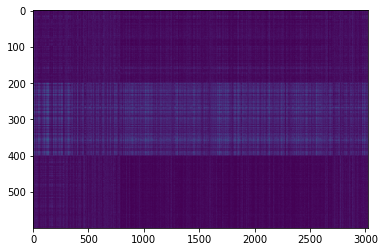

AUC      pAUC
Source_0  0.727100  0.540526
Source_1  0.448300  0.495263
Source_2  0.474700  0.512632
Target_0  0.423300  0.479474
Target_1  0.546800  0.495263
Target_2  0.544800  0.530526
mean      0.527500  0.508947
h_mean    0.511103  0.508063

2021-08-11 13:11:48,037 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:91201.879557, val_AUC_hmean:0.511103, val_pAUC_hmean:0.508063, best_flag:True
2021-08-11 13:11:48,038 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.34it/s]
2021-08-11 13:11:48,479 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.78it/s]
2021-08-11 13:11:48,518 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.51it/s]
2021-08-11 13:11:48,561 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:83977.900391, val_AUC_hmean:0.514909, val_pAUC_hmean:0.502673, best_flag:False
2021-08-11 13:11:48,562 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.53it/s]
2021-08-11 13:11:49,016 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 104.82it/s]
2021-08-11 13:11:49,054 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.78it/s]
2021-08-11 13

100%|██████████| 2/2 [00:00<00:00, 75.77it/s]
2021-08-11 13:11:57,201 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.63it/s]
2021-08-11 13:11:57,248 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:72515.602214, val_AUC_hmean:0.521713, val_pAUC_hmean:0.502983, best_flag:False
2021-08-11 13:11:57,249 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-08-11 13:11:57,706 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.07it/s]
2021-08-11 13:11:57,749 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.91it/s]
2021-08-11 13:11:57,799 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:72417.238281, val_AUC_hmean:0.522114, val_pAUC_hmean:0.503736, best_flag:False
2021-08-11 13:11:57,800 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.94it/s]
2021-08-11 13:11:58,265 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-11 13:12:05,802 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.17it/s]
2021-08-11 13:12:06,230 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.38it/s]
2021-08-11 13:12:06,271 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.29it/s]
2021-08-11 13:12:06,312 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:70429.673828, val_AUC_hmean:0.523982, val_pAUC_hmean:0.503887, best_flag:False
2021-08-11 13:12:06,313 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.97it/s]
2021-08-11 13:12:06,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.72it/s]
2021-08-11 13:12:06,781 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.02it/s]
2021-08-11 13:12:06,821 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:70369.730469, val_AUC_hmean:0.523638, val_pAUC_hmean:0.504526, best_flag:False
2021-08-11

100%|██████████| 2/2 [00:00<00:00, 94.52it/s]
2021-08-11 13:12:14,498 - pytorch_modeler.py - INFO - epoch:51/100, train_losses:69248.687826, val_AUC_hmean:0.524661, val_pAUC_hmean:0.504952, best_flag:False
2021-08-11 13:12:14,499 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.14it/s]
2021-08-11 13:12:14,928 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.94it/s]
2021-08-11 13:12:14,965 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.27it/s]
2021-08-11 13:12:15,007 - pytorch_modeler.py - INFO - epoch:52/100, train_losses:69042.079427, val_AUC_hmean:0.523869, val_pAUC_hmean:0.503826, best_flag:False
2021-08-11 13:12:15,008 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.36it/s]
2021-08-11 13:12:15,448 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.75it/s]
2021-08-11 13:12:15,492 - pytorch_modeler.py - INFO - valid_target
100%|███████

100%|██████████| 12/12 [00:00<00:00, 27.80it/s]
2021-08-11 13:12:23,361 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.08it/s]
2021-08-11 13:12:23,398 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.03it/s]
2021-08-11 13:12:23,448 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:68114.399414, val_AUC_hmean:0.524748, val_pAUC_hmean:0.504637, best_flag:False
2021-08-11 13:12:23,449 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.84it/s]
2021-08-11 13:12:23,898 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.17it/s]
2021-08-11 13:12:23,933 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.25it/s]
2021-08-11 13:12:23,971 - pytorch_modeler.py - INFO - epoch:69/100, train_losses:68048.843099, val_AUC_hmean:0.524658, val_pAUC_hmean:0.503967, best_flag:False
2021-08-11 13:12:23,972 - pytorch_modeler.py - INFO - train
100%|████

100%|██████████| 2/2 [00:00<00:00, 111.27it/s]
2021-08-11 13:12:32,150 - pytorch_modeler.py - INFO - epoch:84/100, train_losses:67006.533529, val_AUC_hmean:0.525129, val_pAUC_hmean:0.505610, best_flag:False
2021-08-11 13:12:32,151 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.33it/s]
2021-08-11 13:12:32,690 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.33it/s]
2021-08-11 13:12:32,725 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.97it/s]
2021-08-11 13:12:32,762 - pytorch_modeler.py - INFO - epoch:85/100, train_losses:66886.132487, val_AUC_hmean:0.523897, val_pAUC_hmean:0.505772, best_flag:False
2021-08-11 13:12:32,763 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.91it/s]
2021-08-11 13:12:33,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.34it/s]
2021-08-11 13:12:33,216 - pytorch_modeler.py - INFO - valid_target
100%|███

AUC      pAUC
Source_0  0.727100  0.540526
Source_1  0.448300  0.495263
Source_2  0.474700  0.512632
Target_0  0.423300  0.479474
Target_1  0.546800  0.495263
Target_2  0.544800  0.530526
mean      0.527500  0.508947
h_mean    0.511103  0.508063

2021-08-11 13:12:40,228 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-08-11 13:12:40,229 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 54.573018789 [sec]


2021-08-11 13:12:40,779 - 00_train.py - INFO - TRAINING
2021-08-11 13:12:41,047 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 28.95it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 28.59it/s]
2021-08-11 13:12:41,469 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.14it/s]
2021-08-11 13:12:41,504 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.57it/s]


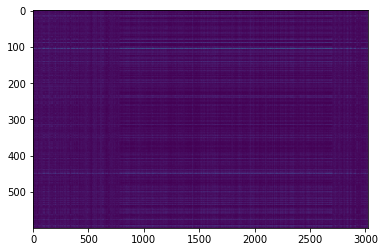

AUC      pAUC
Source_0  0.642000  0.515263
Source_1  0.399700  0.502632
Source_2  0.519100  0.475789
Target_0  0.371600  0.485263
Target_1  0.459200  0.486842
Target_2  0.511900  0.498421
mean      0.483917  0.494035
h_mean    0.468450  0.493698

2021-08-11 13:12:42,581 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:33993.091309, val_AUC_hmean:0.468450, val_pAUC_hmean:0.493698, best_flag:True
2021-08-11 13:12:42,582 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.02it/s]
2021-08-11 13:12:42,997 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 117.22it/s]
2021-08-11 13:12:43,032 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 117.61it/s]


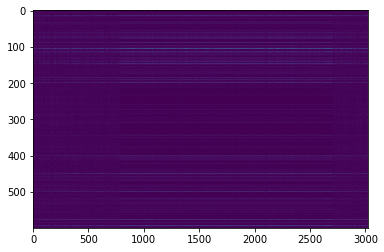

AUC      pAUC
Source_0  0.669500  0.606316
Source_1  0.423300  0.500526
Source_2  0.534400  0.475263
Target_0  0.405300  0.485263
Target_1  0.455600  0.480000
Target_2  0.521700  0.500526
mean      0.501633  0.507982
h_mean    0.487554  0.504487

2021-08-11 13:12:44,109 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:28805.236328, val_AUC_hmean:0.487554, val_pAUC_hmean:0.504487, best_flag:True
2021-08-11 13:12:44,110 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.44it/s]
2021-08-11 13:12:44,535 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.75it/s]
2021-08-11 13:12:44,570 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.65it/s]


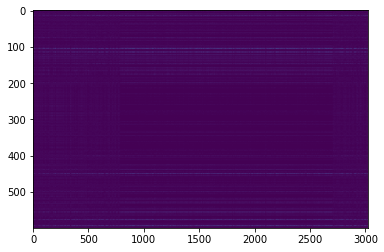

AUC      pAUC
Source_0  0.684800  0.651053
Source_1  0.463400  0.504211
Source_2  0.551700  0.477895
Target_0  0.438600  0.481579
Target_1  0.452400  0.476316
Target_2  0.541500  0.503158
mean      0.522067  0.515702
h_mean    0.509859  0.509546

2021-08-11 13:12:45,641 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:27133.697103, val_AUC_hmean:0.509859, val_pAUC_hmean:0.509546, best_flag:True
2021-08-11 13:12:45,642 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.98it/s]
2021-08-11 13:12:46,058 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.36it/s]
2021-08-11 13:12:46,093 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.35it/s]


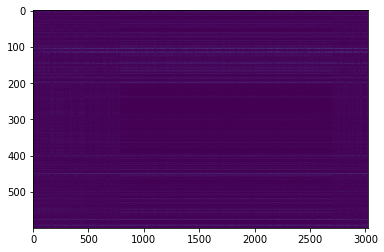

AUC      pAUC
Source_0  0.666200  0.661579
Source_1  0.466700  0.507368
Source_2  0.557600  0.481053
Target_0  0.467200  0.491053
Target_1  0.485600  0.481053
Target_2  0.542400  0.501053
mean      0.530950  0.520526
h_mean    0.522624  0.514038

2021-08-11 13:12:47,162 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:26150.908691, val_AUC_hmean:0.522624, val_pAUC_hmean:0.514038, best_flag:True
2021-08-11 13:12:47,163 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.22it/s]
2021-08-11 13:12:47,576 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.85it/s]
2021-08-11 13:12:47,610 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.80it/s]


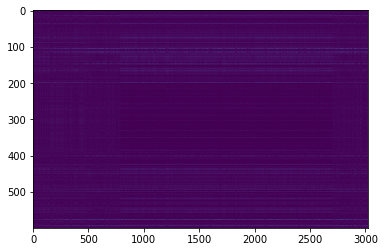

AUC      pAUC
Source_0  0.657300  0.651053
Source_1  0.398100  0.518421
Source_2  0.547000  0.493684
Target_0  0.505800  0.505789
Target_1  0.551300  0.501053
Target_2  0.544800  0.508421
mean      0.534050  0.529737
h_mean    0.522286  0.524922

2021-08-11 13:12:48,719 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:25302.327311, val_AUC_hmean:0.522286, val_pAUC_hmean:0.524922, best_flag:True
2021-08-11 13:12:48,720 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.99it/s]
2021-08-11 13:12:49,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.62it/s]
2021-08-11 13:12:49,170 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 118.00it/s]


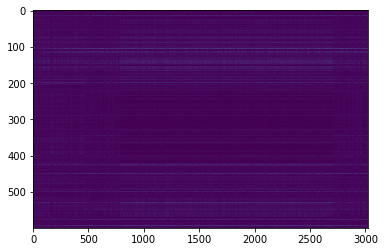

AUC      pAUC
Source_0  0.65780  0.648947
Source_1  0.41990  0.530000
Source_2  0.54140  0.490526
Target_0  0.53520  0.513684
Target_1  0.55390  0.495789
Target_2  0.56300  0.504737
mean      0.54520  0.530614
h_mean    0.53577  0.525794

2021-08-11 13:12:50,297 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:24569.165202, val_AUC_hmean:0.535770, val_pAUC_hmean:0.525794, best_flag:True
2021-08-11 13:12:50,298 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.69it/s]
2021-08-11 13:12:50,828 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 105.77it/s]
2021-08-11 13:12:50,868 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.39it/s]
2021-08-11 13:12:50,906 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:23995.120280, val_AUC_hmean:0.547459, val_pAUC_hmean:0.525353, best_flag:False
2021-08-11 13:12:50,907 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.84it/s]
2021-08-11 13:12:51,325 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.76it/s]
2021-08-11 13:12:51,359 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.10it/s]


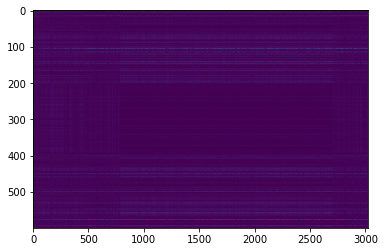

AUC      pAUC
Source_0  0.651600  0.623158
Source_1  0.478800  0.543158
Source_2  0.530800  0.491053
Target_0  0.597100  0.517895
Target_1  0.512900  0.494211
Target_2  0.573100  0.514211
mean      0.557383  0.530614
h_mean    0.551646  0.527180

2021-08-11 13:12:52,469 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:23347.358073, val_AUC_hmean:0.551646, val_pAUC_hmean:0.527180, best_flag:True
2021-08-11 13:12:52,470 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.68it/s]
2021-08-11 13:12:52,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.68it/s]
2021-08-11 13:12:52,926 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.59it/s]


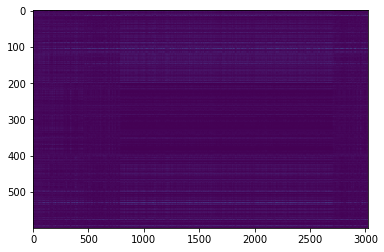

AUC      pAUC
Source_0  0.665800  0.603158
Source_1  0.477300  0.551053
Source_2  0.552800  0.494211
Target_0  0.607900  0.518947
Target_1  0.495900  0.489474
Target_2  0.590700  0.523684
mean      0.565067  0.530088
h_mean    0.557595  0.527444

2021-08-11 13:12:54,065 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:22782.850098, val_AUC_hmean:0.557595, val_pAUC_hmean:0.527444, best_flag:True
2021-08-11 13:12:54,066 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.84it/s]
2021-08-11 13:12:54,532 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.55it/s]
2021-08-11 13:12:54,568 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.24it/s]


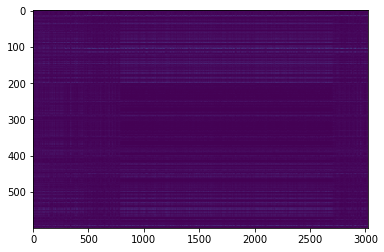

AUC      pAUC
Source_0  0.678100  0.609474
Source_1  0.562100  0.554737
Source_2  0.540800  0.500000
Target_0  0.569400  0.526316
Target_1  0.497000  0.488421
Target_2  0.607800  0.541579
mean      0.575867  0.536754
h_mean    0.570535  0.533937

2021-08-11 13:12:55,675 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:22271.361328, val_AUC_hmean:0.570535, val_pAUC_hmean:0.533937, best_flag:True
2021-08-11 13:12:55,675 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.62it/s]
2021-08-11 13:12:56,097 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.74it/s]
2021-08-11 13:12:56,133 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.12it/s]
2021-08-11 13:12:56,170 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:21724.883789, val_AUC_hmean:0.590015, val_pAUC_hmean:0.531722, best_flag:False
2021-08-11 13:12:56,171 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.09it/s]
2021-08-11 13:12:56,600 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 104.29it/s]
2021-08-11 13:12:56,638 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.42it/s]
2021-08-11

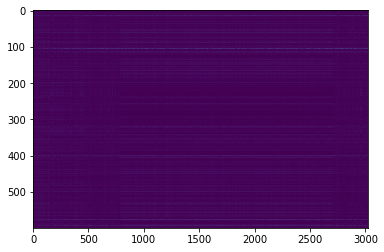

AUC      pAUC
Source_0  0.682500  0.607368
Source_1  0.590000  0.550000
Source_2  0.599200  0.507895
Target_0  0.596600  0.516842
Target_1  0.530600  0.490000
Target_2  0.604300  0.549474
mean      0.600533  0.536930
h_mean    0.597334  0.534326

2021-08-11 13:13:00,214 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:19509.612956, val_AUC_hmean:0.597334, val_pAUC_hmean:0.534326, best_flag:True
2021-08-11 13:13:00,214 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.78it/s]
2021-08-11 13:13:00,633 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.52it/s]
2021-08-11 13:13:00,668 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 117.91it/s]
2021-08-11 13:13:00,705 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:19144.854655, val_AUC_hmean:0.596347, val_pAUC_hmean:0.533529, best_flag:False
2021-08-11 13:13:00,706 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.70it/s]
2021-08-11 13:13:01,126 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.50it/s]
2021-08-11 13:13:01,161 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.40it/s]
2021-08-1

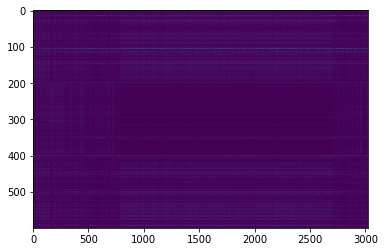

AUC      pAUC
Source_0  0.665400  0.642105
Source_1  0.590000  0.551579
Source_2  0.574500  0.506316
Target_0  0.582200  0.517895
Target_1  0.529800  0.490000
Target_2  0.555800  0.528947
mean      0.582950  0.539474
h_mean    0.580116  0.535348

2021-08-11 13:13:03,234 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:18380.980632, val_AUC_hmean:0.580116, val_pAUC_hmean:0.535348, best_flag:True
2021-08-11 13:13:03,235 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.36it/s]
2021-08-11 13:13:03,660 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.76it/s]
2021-08-11 13:13:03,696 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.49it/s]
2021-08-11 13:13:03,735 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:18187.253092, val_AUC_hmean:0.575641, val_pAUC_hmean:0.532109, best_flag:False
2021-08-11 13:13:03,736 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.62it/s]
2021-08-11 13:13:04,189 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 110.06it/s]
2021-08-11 13:13:04,225 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.88it/s]
2021-08-1

100%|██████████| 12/12 [00:00<00:00, 28.74it/s]
2021-08-11 13:13:11,854 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.04it/s]
2021-08-11 13:13:11,888 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.88it/s]
2021-08-11 13:13:11,926 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:14923.409993, val_AUC_hmean:0.605917, val_pAUC_hmean:0.518555, best_flag:False
2021-08-11 13:13:11,927 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.81it/s]
2021-08-11 13:13:12,345 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.73it/s]
2021-08-11 13:13:12,379 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.07it/s]
2021-08-11 13:13:12,416 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:14916.146240, val_AUC_hmean:0.595323, val_pAUC_hmean:0.519811, best_flag:False
2021-08-11 13:13:12,417 - pytorch_modeler.py - INFO - train
100%|███

100%|██████████| 2/2 [00:00<00:00, 112.27it/s]
2021-08-11 13:13:20,218 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:12965.188314, val_AUC_hmean:0.590581, val_pAUC_hmean:0.517786, best_flag:False
2021-08-11 13:13:20,219 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.85it/s]
2021-08-11 13:13:20,668 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.63it/s]
2021-08-11 13:13:20,704 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.99it/s]
2021-08-11 13:13:20,744 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:12911.143717, val_AUC_hmean:0.597825, val_pAUC_hmean:0.521420, best_flag:False
2021-08-11 13:13:20,745 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.53it/s]
2021-08-11 13:13:21,167 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.96it/s]
2021-08-11 13:13:21,203 - pytorch_modeler.py - INFO - valid_target
100%|███

100%|██████████| 12/12 [00:00<00:00, 27.41it/s]
2021-08-11 13:13:28,785 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 107.08it/s]
2021-08-11 13:13:28,823 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.10it/s]
2021-08-11 13:13:28,863 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:11648.853678, val_AUC_hmean:0.593445, val_pAUC_hmean:0.516093, best_flag:False
2021-08-11 13:13:28,865 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.26it/s]
2021-08-11 13:13:29,291 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 110.53it/s]
2021-08-11 13:13:29,326 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.37it/s]
2021-08-11 13:13:29,371 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:11445.525553, val_AUC_hmean:0.588711, val_pAUC_hmean:0.518153, best_flag:False
2021-08-11 13:13:29,372 - pytorch_modeler.py - INFO - train
100%|███

100%|██████████| 2/2 [00:00<00:00, 115.86it/s]
2021-08-11 13:13:37,410 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:10400.517334, val_AUC_hmean:0.573644, val_pAUC_hmean:0.513370, best_flag:False
2021-08-11 13:13:37,411 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.06it/s]
2021-08-11 13:13:37,825 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.92it/s]
2021-08-11 13:13:37,860 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.25it/s]
2021-08-11 13:13:37,898 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:10248.120768, val_AUC_hmean:0.588301, val_pAUC_hmean:0.520835, best_flag:False
2021-08-11 13:13:37,899 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.55it/s]
2021-08-11 13:13:38,321 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.02it/s]
2021-08-11 13:13:38,355 - pytorch_modeler.py - INFO - valid_target
100%|███

AUC      pAUC
Source_0  0.665400  0.642105
Source_1  0.590000  0.551579
Source_2  0.574500  0.506316
Target_0  0.582200  0.517895
Target_1  0.529800  0.490000
Target_2  0.555800  0.528947
mean      0.582950  0.539474
h_mean    0.580116  0.535348

2021-08-11 13:13:43,971 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-08-11 13:13:43,972 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 63.742656469 [sec]


2021-08-11 13:13:44,544 - 00_train.py - INFO - TRAINING
2021-08-11 13:13:44,830 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 28.46it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 28.50it/s]
2021-08-11 13:13:45,253 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.26it/s]
2021-08-11 13:13:45,294 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.49it/s]


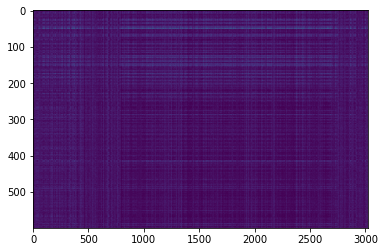

AUC      pAUC
Source_0  0.523900  0.511053
Source_1  0.430700  0.504737
Source_2  0.659000  0.568421
Target_0  0.580000  0.497895
Target_1  0.548200  0.495263
Target_2  0.624900  0.548947
mean      0.561117  0.521053
h_mean    0.550633  0.519638

2021-08-11 13:13:46,459 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:33632.805501, val_AUC_hmean:0.550633, val_pAUC_hmean:0.519638, best_flag:True
2021-08-11 13:13:46,461 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.49it/s]
2021-08-11 13:13:46,899 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.45it/s]
2021-08-11 13:13:46,942 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.64it/s]


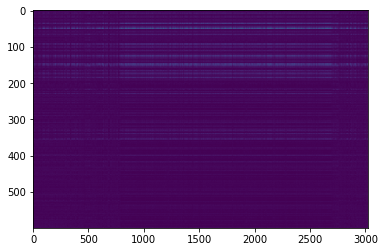

AUC      pAUC
Source_0  0.539200  0.499474
Source_1  0.461100  0.504211
Source_2  0.660100  0.583158
Target_0  0.594400  0.494737
Target_1  0.559900  0.511053
Target_2  0.568100  0.535263
mean      0.563800  0.521316
h_mean    0.557263  0.519639

2021-08-11 13:13:48,158 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:28389.120768, val_AUC_hmean:0.557263, val_pAUC_hmean:0.519639, best_flag:True
2021-08-11 13:13:48,159 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.08it/s]
2021-08-11 13:13:48,589 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 105.63it/s]
2021-08-11 13:13:48,627 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.57it/s]
2021-08-11 13:13:48,668 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:26614.677734, val_AUC_hmean:0.552811, val_pAUC_hmean:0.515272, best_flag:False
2021-08-11 13:13:48,669 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-08-11 13:13:49,129 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.83it/s]
2021-08-11 13:13:49,167 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.71it/s]
2021-08-11 

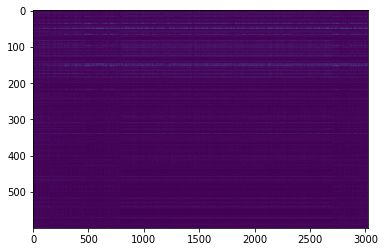

AUC      pAUC
Source_0  0.547800  0.493684
Source_1  0.505000  0.523158
Source_2  0.713100  0.616316
Target_0  0.559100  0.512105
Target_1  0.536000  0.513684
Target_2  0.517400  0.498421
mean      0.563067  0.526228
h_mean    0.555812  0.523315

2021-08-11 13:13:52,279 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:21468.850586, val_AUC_hmean:0.555812, val_pAUC_hmean:0.523315, best_flag:True
2021-08-11 13:13:52,280 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.52it/s]
2021-08-11 13:13:52,702 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.88it/s]
2021-08-11 13:13:52,737 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.05it/s]
2021-08-11 13:13:52,776 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:20874.965983, val_AUC_hmean:0.568394, val_pAUC_hmean:0.518526, best_flag:False
2021-08-11 13:13:52,777 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.11it/s]
2021-08-11 13:13:53,206 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.08it/s]
2021-08-11 13:13:53,240 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.16it/s]
2021-08-11 

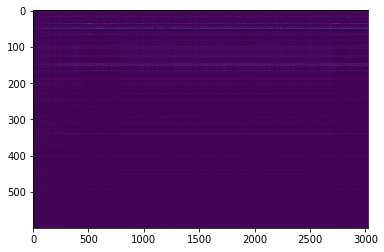

AUC      pAUC
Source_0  0.448500  0.477895
Source_1  0.633500  0.531579
Source_2  0.710600  0.633684
Target_0  0.541500  0.509474
Target_1  0.579700  0.520000
Target_2  0.559700  0.546842
mean      0.578917  0.536579
h_mean    0.567436  0.532560

2021-08-11 13:14:00,414 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:15921.478923, val_AUC_hmean:0.567436, val_pAUC_hmean:0.532560, best_flag:True
2021-08-11 13:14:00,415 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.57it/s]
2021-08-11 13:14:00,853 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 110.58it/s]
2021-08-11 13:14:00,890 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.30it/s]
2021-08-11 13:14:00,933 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:15636.829834, val_AUC_hmean:0.574610, val_pAUC_hmean:0.522178, best_flag:False
2021-08-11 13:14:00,934 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.61it/s]
2021-08-11 13:14:01,405 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.88it/s]
2021-08-11 13:14:01,446 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.56it/s]
2021-08-11 

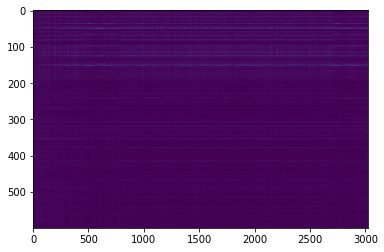

AUC      pAUC
Source_0  0.456100  0.481053
Source_1  0.605600  0.520526
Source_2  0.716400  0.647368
Target_0  0.514000  0.493158
Target_1  0.592800  0.509474
Target_2  0.561600  0.578421
mean      0.574417  0.538333
h_mean    0.563238  0.532669

2021-08-11 13:14:04,773 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:14724.053630, val_AUC_hmean:0.563238, val_pAUC_hmean:0.532669, best_flag:True
2021-08-11 13:14:04,774 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.69it/s]
2021-08-11 13:14:05,194 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.43it/s]
2021-08-11 13:14:05,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.07it/s]
2021-08-11 13:14:05,270 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:14543.795898, val_AUC_hmean:0.570609, val_pAUC_hmean:0.526975, best_flag:False
2021-08-11 13:14:05,271 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.78it/s]
2021-08-11 13:14:05,690 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 107.50it/s]
2021-08-11 13:14:05,727 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.25it/s]
2021-08-1

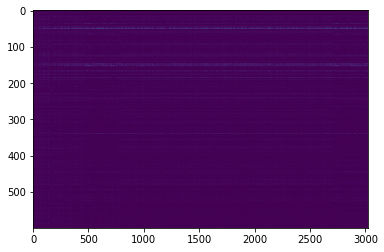

AUC      pAUC
Source_0  0.469400  0.490000
Source_1  0.638500  0.520000
Source_2  0.722000  0.650000
Target_0  0.558400  0.507368
Target_1  0.597100  0.511053
Target_2  0.537400  0.547895
mean      0.587133  0.537719
h_mean    0.576480  0.533086

2021-08-11 13:14:09,934 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:13343.797201, val_AUC_hmean:0.576480, val_pAUC_hmean:0.533086, best_flag:True
2021-08-11 13:14:09,935 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.49it/s]
2021-08-11 13:14:10,391 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 105.33it/s]
2021-08-11 13:14:10,429 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.44it/s]
2021-08-11 13:14:10,469 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:13284.658691, val_AUC_hmean:0.560938, val_pAUC_hmean:0.513105, best_flag:False
2021-08-11 13:14:10,470 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.18it/s]
2021-08-11 13:14:10,898 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.22it/s]
2021-08-11 13:14:10,934 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.52it/s]


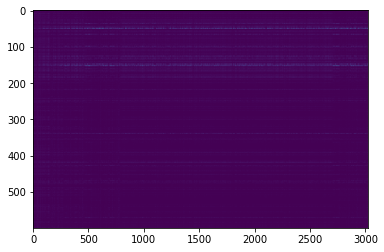

AUC      pAUC
Source_0  0.478700  0.489474
Source_1  0.623100  0.522632
Source_2  0.700800  0.610000
Target_0  0.586000  0.520000
Target_1  0.597800  0.511579
Target_2  0.571500  0.570526
mean      0.592983  0.537368
h_mean    0.585373  0.534458

2021-08-11 13:14:12,276 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:13276.656576, val_AUC_hmean:0.585373, val_pAUC_hmean:0.534458, best_flag:True
2021-08-11 13:14:12,277 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.79it/s]
2021-08-11 13:14:12,711 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.53it/s]
2021-08-11 13:14:12,751 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 105.82it/s]
2021-08-11 13:14:12,793 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:13168.223958, val_AUC_hmean:0.576192, val_pAUC_hmean:0.532030, best_flag:False
2021-08-11 13:14:12,794 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.35it/s]
2021-08-11 13:14:13,235 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 105.36it/s]
2021-08-11 13:14:13,277 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.02it/s]
2021-08-11

100%|██████████| 2/2 [00:00<00:00, 100.44it/s]
2021-08-11 13:14:21,133 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.61it/s]
2021-08-11 13:14:21,174 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:11357.033285, val_AUC_hmean:0.577673, val_pAUC_hmean:0.523850, best_flag:False
2021-08-11 13:14:21,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.68it/s]
2021-08-11 13:14:21,626 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.12it/s]
2021-08-11 13:14:21,663 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.37it/s]
2021-08-11 13:14:21,704 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:11283.919596, val_AUC_hmean:0.568799, val_pAUC_hmean:0.527237, best_flag:False
2021-08-11 13:14:21,705 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.84it/s]
2021-08-11 13:14:22,122 - pytorch_modeler.py - INFO - valid_source
100%|███

2021-08-11 13:14:29,339 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.68it/s]
2021-08-11 13:14:29,894 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.77it/s]
2021-08-11 13:14:29,932 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.73it/s]
2021-08-11 13:14:29,972 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:10015.564046, val_AUC_hmean:0.567020, val_pAUC_hmean:0.520025, best_flag:False
2021-08-11 13:14:29,973 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.37it/s]
2021-08-11 13:14:30,413 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.34it/s]
2021-08-11 13:14:30,450 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.50it/s]
2021-08-11 13:14:30,490 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:10036.956136, val_AUC_hmean:0.574491, val_pAUC_hmean:0.520838, best_flag:False
2021-08-

100%|██████████| 2/2 [00:00<00:00, 114.33it/s]
2021-08-11 13:14:38,068 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:8980.889323, val_AUC_hmean:0.579118, val_pAUC_hmean:0.527733, best_flag:False
2021-08-11 13:14:38,070 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.75it/s]
2021-08-11 13:14:38,489 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.11it/s]
2021-08-11 13:14:38,525 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.22it/s]
2021-08-11 13:14:38,564 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:8936.743164, val_AUC_hmean:0.564114, val_pAUC_hmean:0.519920, best_flag:False
2021-08-11 13:14:38,565 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.66it/s]
2021-08-11 13:14:38,986 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 110.07it/s]
2021-08-11 13:14:39,022 - pytorch_modeler.py - INFO - valid_target
100%|█████

AUC      pAUC
Source_0  0.478700  0.489474
Source_1  0.623100  0.522632
Source_2  0.700800  0.610000
Target_0  0.586000  0.520000
Target_1  0.597800  0.511579
Target_2  0.571500  0.570526
mean      0.592983  0.537368
h_mean    0.585373  0.534458

2021-08-11 13:14:44,622 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-08-11 13:14:44,623 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 60.647426605 [sec]


2021-08-11 13:14:45,183 - 00_train.py - INFO - TRAINING
2021-08-11 13:14:45,454 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 28.69it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 28.81it/s]
2021-08-11 13:14:45,872 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.69it/s]
2021-08-11 13:14:45,907 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.45it/s]


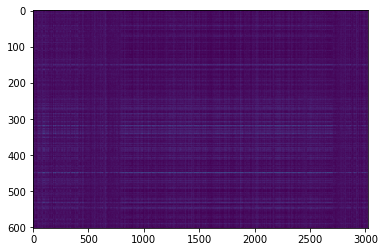

AUC      pAUC
Source_0  0.545100  0.500526
Source_1  0.394200  0.485263
Source_2  0.588414  0.515433
Target_0  0.527300  0.508421
Target_1  0.425510  0.486466
Target_2  0.552191  0.504947
mean      0.505453  0.500176
h_mean    0.494709  0.499930

2021-08-11 13:14:47,028 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:32483.475098, val_AUC_hmean:0.494709, val_pAUC_hmean:0.499930, best_flag:True
2021-08-11 13:14:47,028 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.96it/s]
2021-08-11 13:14:47,445 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.04it/s]
2021-08-11 13:14:47,481 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.35it/s]


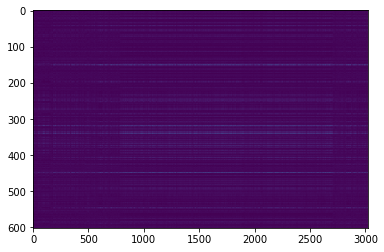

AUC      pAUC
Source_0  0.623500  0.501053
Source_1  0.437400  0.485789
Source_2  0.629768  0.527160
Target_0  0.570300  0.496842
Target_1  0.410510  0.484318
Target_2  0.583333  0.512536
mean      0.542469  0.501283
h_mean    0.527161  0.500842

2021-08-11 13:14:48,563 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:27069.724935, val_AUC_hmean:0.527161, val_pAUC_hmean:0.500842, best_flag:True
2021-08-11 13:14:48,564 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.83it/s]
2021-08-11 13:14:48,982 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.36it/s]
2021-08-11 13:14:49,017 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.03it/s]


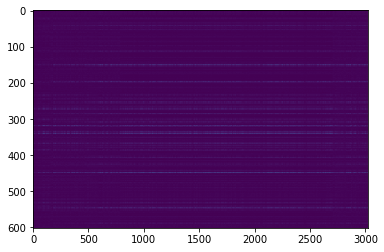

AUC      pAUC
Source_0  0.647000  0.508947
Source_1  0.484700  0.495789
Source_2  0.650267  0.552491
Target_0  0.615000  0.549474
Target_1  0.412449  0.482707
Target_2  0.590638  0.541674
mean      0.566676  0.521847
h_mean    0.550954  0.520404

2021-08-11 13:14:50,098 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:24966.825846, val_AUC_hmean:0.550954, val_pAUC_hmean:0.520404, best_flag:True
2021-08-11 13:14:50,099 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.75it/s]
2021-08-11 13:14:50,518 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.68it/s]
2021-08-11 13:14:50,554 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.49it/s]


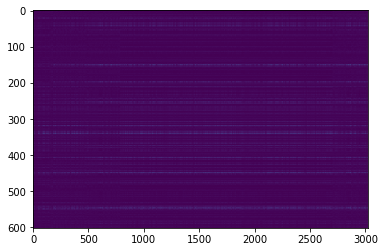

AUC      pAUC
Source_0  0.660800  0.538421
Source_1  0.549700  0.508947
Source_2  0.688503  0.593301
Target_0  0.628800  0.610526
Target_1  0.394796  0.481955
Target_2  0.601884  0.573241
mean      0.587414  0.551065
h_mean    0.567663  0.547201

2021-08-11 13:14:51,646 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:23305.965983, val_AUC_hmean:0.567663, val_pAUC_hmean:0.547201, best_flag:True
2021-08-11 13:14:51,647 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.02it/s]
2021-08-11 13:14:52,062 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.83it/s]
2021-08-11 13:14:52,098 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.38it/s]
2021-08-11 13:14:52,135 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:21998.650228, val_AUC_hmean:0.543128, val_pAUC_hmean:0.538517, best_flag:False
2021-08-11 13:14:52,136 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.08it/s]
2021-08-11 13:14:52,565 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.49it/s]
2021-08-11 13:14:52,601 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.01it/s]


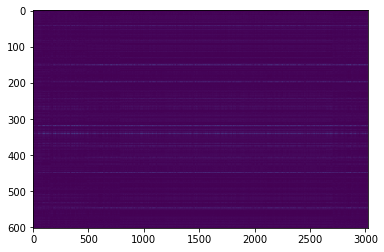

AUC      pAUC
Source_0  0.658100  0.550526
Source_1  0.545900  0.495789
Source_2  0.720766  0.629890
Target_0  0.616800  0.604211
Target_1  0.363673  0.481633
Target_2  0.580161  0.562011
mean      0.580900  0.554010
h_mean    0.553842  0.548865

2021-08-11 13:14:53,722 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:20907.569173, val_AUC_hmean:0.553842, val_pAUC_hmean:0.548865, best_flag:True
2021-08-11 13:14:53,723 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.77it/s]
2021-08-11 13:14:54,142 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.42it/s]
2021-08-11 13:14:54,176 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.28it/s]
2021-08-11 13:14:54,213 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:19901.250814, val_AUC_hmean:0.529217, val_pAUC_hmean:0.538249, best_flag:False
2021-08-11 13:14:54,214 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.18it/s]
2021-08-11 13:14:54,627 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.33it/s]
2021-08-11 13:14:54,662 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.07it/s]
2021-08-11 

100%|██████████| 12/12 [00:00<00:00, 28.49it/s]
2021-08-11 13:15:02,214 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.56it/s]
2021-08-11 13:15:02,252 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.98it/s]
2021-08-11 13:15:02,292 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:13887.763346, val_AUC_hmean:0.571408, val_pAUC_hmean:0.540181, best_flag:False
2021-08-11 13:15:02,293 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.70it/s]
2021-08-11 13:15:02,713 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.70it/s]
2021-08-11 13:15:02,748 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.14it/s]
2021-08-11 13:15:02,788 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:13834.663411, val_AUC_hmean:0.526771, val_pAUC_hmean:0.524603, best_flag:False
2021-08-11 13:15:02,789 - pytorch_modeler.py - INFO - train
100%|███

100%|██████████| 2/2 [00:00<00:00, 112.54it/s]
2021-08-11 13:15:10,231 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:11851.345296, val_AUC_hmean:0.557653, val_pAUC_hmean:0.529893, best_flag:False
2021-08-11 13:15:10,232 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.43it/s]
2021-08-11 13:15:10,656 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.19it/s]
2021-08-11 13:15:10,692 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.62it/s]
2021-08-11 13:15:10,732 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:11764.882650, val_AUC_hmean:0.552117, val_pAUC_hmean:0.530204, best_flag:False
2021-08-11 13:15:10,733 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.21it/s]
2021-08-11 13:15:11,161 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.11it/s]
2021-08-11 13:15:11,195 - pytorch_modeler.py - INFO - valid_target
100%|███

100%|██████████| 12/12 [00:00<00:00, 28.00it/s]
2021-08-11 13:15:18,725 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.17it/s]
2021-08-11 13:15:18,760 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.14it/s]
2021-08-11 13:15:18,798 - pytorch_modeler.py - INFO - epoch:56/100, train_losses:10347.936768, val_AUC_hmean:0.570049, val_pAUC_hmean:0.536431, best_flag:False
2021-08-11 13:15:18,799 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.03it/s]
2021-08-11 13:15:19,214 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.60it/s]
2021-08-11 13:15:19,249 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.57it/s]
2021-08-11 13:15:19,288 - pytorch_modeler.py - INFO - epoch:57/100, train_losses:10346.304362, val_AUC_hmean:0.572964, val_pAUC_hmean:0.540778, best_flag:False
2021-08-11 13:15:19,289 - pytorch_modeler.py - INFO - train
100%|███

100%|██████████| 2/2 [00:00<00:00, 111.21it/s]
2021-08-11 13:15:26,883 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:9096.823730, val_AUC_hmean:0.561840, val_pAUC_hmean:0.539616, best_flag:False
2021-08-11 13:15:26,884 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.22it/s]
2021-08-11 13:15:27,311 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 101.55it/s]
2021-08-11 13:15:27,350 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.62it/s]
2021-08-11 13:15:27,390 - pytorch_modeler.py - INFO - epoch:73/100, train_losses:8966.033773, val_AUC_hmean:0.565580, val_pAUC_hmean:0.533028, best_flag:False
2021-08-11 13:15:27,392 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.73it/s]
2021-08-11 13:15:27,842 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.64it/s]
2021-08-11 13:15:27,879 - pytorch_modeler.py - INFO - valid_target
100%|█████

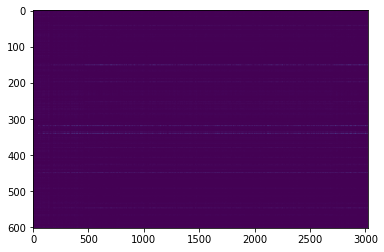

AUC      pAUC
Source_0  0.705800  0.593684
Source_1  0.697000  0.549474
Source_2  0.776738  0.684773
Target_0  0.566500  0.493684
Target_1  0.395408  0.484103
Target_2  0.544983  0.536514
mean      0.614405  0.557039
h_mean    0.584330  0.549460

2021-08-11 13:15:32,402 - pytorch_modeler.py - INFO - epoch:80/100, train_losses:8610.460775, val_AUC_hmean:0.584330, val_pAUC_hmean:0.549460, best_flag:True
2021-08-11 13:15:32,403 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.50it/s]
2021-08-11 13:15:32,826 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.90it/s]
2021-08-11 13:15:32,862 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.68it/s]
2021-08-11 13:15:32,900 - pytorch_modeler.py - INFO - epoch:81/100, train_losses:8642.662598, val_AUC_hmean:0.550781, val_pAUC_hmean:0.548651, best_flag:False
2021-08-11 13:15:32,901 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.19it/s]
2021-08-11 13:15:33,329 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.66it/s]
2021-08-11 13:15:33,364 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.47it/s]
2021-08-11 

100%|██████████| 2/2 [00:00<00:00, 107.44it/s]
2021-08-11 13:15:41,074 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.93it/s]
2021-08-11 13:15:41,117 - pytorch_modeler.py - INFO - epoch:97/100, train_losses:7706.763143, val_AUC_hmean:0.564235, val_pAUC_hmean:0.535961, best_flag:False
2021-08-11 13:15:41,118 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.52it/s]
2021-08-11 13:15:41,541 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 107.99it/s]
2021-08-11 13:15:41,578 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.00it/s]
2021-08-11 13:15:41,619 - pytorch_modeler.py - INFO - epoch:98/100, train_losses:7657.971720, val_AUC_hmean:0.556209, val_pAUC_hmean:0.528867, best_flag:False
2021-08-11 13:15:41,620 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.09it/s]
2021-08-11 13:15:42,049 - pytorch_modeler.py - INFO - valid_source
100%|██████

AUC      pAUC
Source_0  0.705800  0.593684
Source_1  0.697000  0.549474
Source_2  0.776738  0.684773
Target_0  0.566500  0.493684
Target_1  0.395408  0.484103
Target_2  0.544983  0.536514
mean      0.614405  0.557039
h_mean    0.584330  0.549460

elapsed time: 58.047574997 [sec]


In [18]:
for machine_type in machine_types:
     run(machine_type)

In [19]:
#run(machine_types[1])